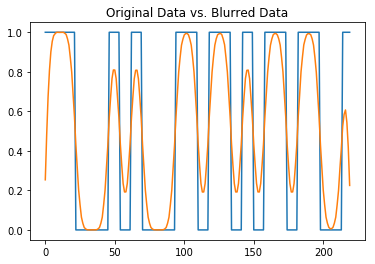

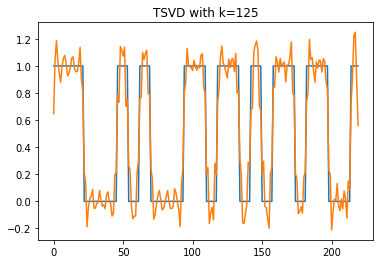

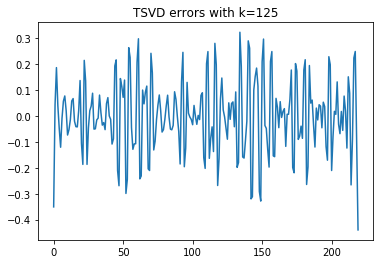

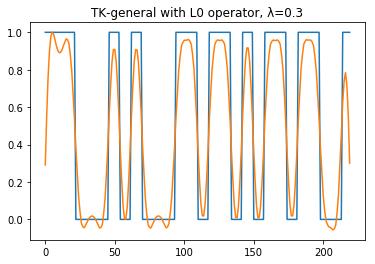

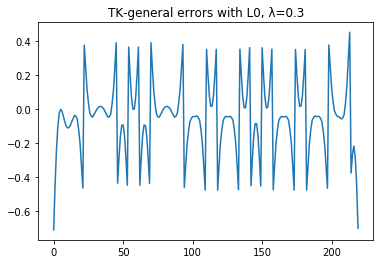

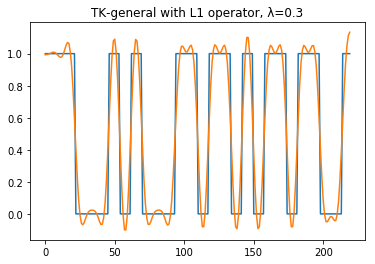

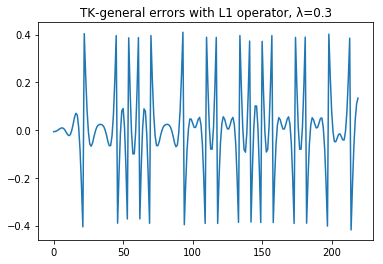

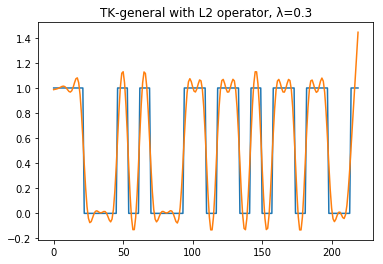

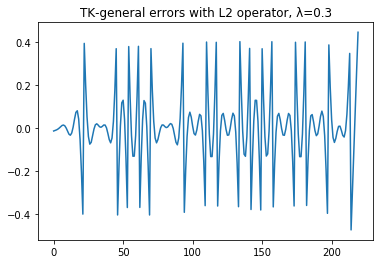

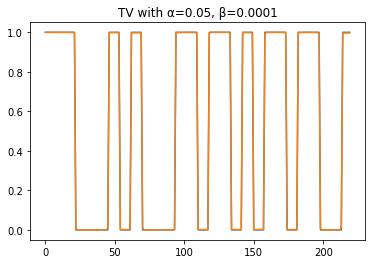

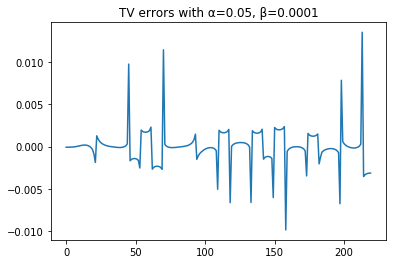

SystemExit: 0

In [14]:
#!/usr/bin/env python3
# coding: utf-8

###################################################
# Script for de-blurring an image                 #
# uses TSVD and Tikhonov regularization           #
# using first and second derivative ops           #
# and Total Variance                              #
#                                                 #
# Author: Merlin Carson                           #
# Date: Oct-30-2019                               #
###################################################

import sys
import cv2
import numpy as np
from scipy.sparse import diags
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.optimize as opt


def plt_error(error1, title=None):

    plt.title(title)
    plt.plot(error1)
    #plt.plot(error2)
    plt.show()

def plt_compare(data1, data2, title=None, pause=True):

    plt.plot(data1)
    plt.plot(data2)
    plt.title(title)
    if pause:
        plt.show()
    else:
        plt.draw()
        plt.pause(0.01)

def plot_l_curve(norms, residuals):

    plt.figure()
    plt.title(f'L-Curve')
    plt.ylabel('$||X_λ||$')
    plt.xlabel('||$A{X_λ}-\hat{D}$||')
    plt.yscale('log', basey=10)
    #plt.xticks(residuals)
    plt.grid()
    plt.plot(residuals, norms)
    #plt.xlim(residuals[-1],residuals[0])
    plt.show()


# create diffusion matrix n x m
def diffusion_matrix(L, n, m):

    # make matrix tridiagonal 
    # 1-2*L as diagonal and L above and below diagonal
    return diags([L, 1-2*L, L], [-1, 0, 1], shape = (n,m)).toarray()


def solve(U, S, V, dhat, p, method):
    fltr = 1.0
    xhat = np.zeros((dhat.shape[0]))
    
    if method is 'TK':
        n = S.shape[0]  # use all singular values
    else:
        n = p           # truncate singular values

    for i in range(n):
        # determine filter factor based on method
        if method is 'TK':
            fltr = S[i]**2/(S[i]**2 + p**2) 

        xi = fltr * (np.dot(U[:,i].T, dhat)/S[i]) * V[:,i]
        xhat = np.add(xhat, xi)

    return np.expand_dims(xhat, axis=1) 

    
def regularize(A, Dhat, method, Lop=0, p=0, Lambda=0, alpha=0, beta=0):
   
    m, n = Dhat.shape               

    Xhat = np.empty((m,0))

    if Lop == 0:
        L = np.eye(m)
    elif Lop == 1:
        L = diags([-1, 1], [0, 1], shape = (m-1,m)).toarray()
    elif Lop == 2:
        L = diags([1, -2, 1], [0, 1, 2], shape = (m-2,m)).toarray()

    for i in range(n):
        dhat = Dhat[:,i]

        if method in ['TK', 'TSVD']:
            U, S, Vt = np.linalg.svd(A)
            xhat = solve(U, S, Vt.T, dhat, p, method) 
        elif method in ['TK-gen']:
            xhat = tk_general(A, Lambda, L, dhat)
        elif method in ['TV']:
            xhat = total_variation(A, alpha, beta, dhat)
        else:
            sys.exit(f'Unknown method {method}')

        Xhat = np.hstack((Xhat, xhat)) 

    return Xhat 


def tk_general(A, lambdaL, L, dhat):
    term1 = np.linalg.inv(np.matmul(A.T,A)+lambdaL**2*np.matmul(L.T,L))
    term2 = np.matmul(A.T,dhat)
    return np.expand_dims(np.matmul(term1,term2), axis=1)


def total_variation(A, alpha, beta, dhat):
    x0 = 0.5 * np.ones(dhat.shape)
    params = (A,alpha,beta,dhat)

    xhat = opt.minimize(J_alpha_beta, x0, args=params)['x']
    
    return np.expand_dims(xhat, axis=1)


def J_alpha_beta(xhat, *params):
    A, alpha, beta, dhat = params[0], params[1], params[2], params[3]
    return np.linalg.norm(A@xhat-dhat)**2 + alpha**2 * smoothing_approx(xhat,beta)


def smoothing_approx(xhat, beta):
    T = 0 
    for i in range(xhat.shape[0]-1):
        T += np.sqrt(beta**2 + np.abs(xhat[i+1]-xhat[i])**2)
    return T


def de_blur(A, X, Dhat, method):
    n = A.shape[0] 
    norms = []
    residuals = []
    if method is 'TSVD':
        print('Regularizing with Truncated Singular Value Decomposition')
        for k in tqdm(range(50,150)):  # try all truncation values to find best fit
            Xhat = regularize(A, Dhat, method, k)
            norm = np.linalg.norm(Xhat)
            norms.append(norm)
            res = np.linalg.norm(np.subtract(np.matmul(A,Xhat),Dhat))
            residuals.append(res)
            plt_compare(Xhat, X, title=f'k={k}', pause=False)
    elif method is 'TK':
        print('Regularizing with Tikhonov Regularization')
        residuals = []
        for Lambda in tqdm(np.arange(0.000001,1.0,0.001)):  # try all truncation values to find best fit
            Xhat = regularize(A, Dhat, method, Lambda)
            norm = np.linalg.norm(Xhat)
            norms.append(norm)
            res = np.linalg.norm(np.subtract(np.matmul(A,Xhat),Dhat))
            residuals.append(res)
            #show_img(Xhat, title=f'λ={Lambda}', pause=False)


    else:
        sys.exit('Unknown method') 

    plot_l_curve(norms, residuals)

def load_data_m(dataFile):
    Dhat = []
    with open(dataFile, 'r') as data:
        for row in data.readlines():
            Dhat.append([float(val) for val in row.split()])

    return np.array(Dhat)


def main():

    # open image
    imgFile = 'hw2blur.jpg'
    dataFile = 'BlurData.m'
    trueData = 'TrueData.m'
    #Dhat = cv2.imread(imgFile,0)

    Dhat = load_data_m(dataFile) 
    X = load_data_m(trueData)

    # display Blurred data and True data 
    plt_compare(X, Dhat, title='Original Data vs. Blurred Data' )


    n, m = Dhat.shape       # dims of image
    L = 0.45                # diagonal val for blurring matrix
    blur_op_power = 10      # power to raise the blurring operator matrix by
   
    # create blurring matrix 
    B = diffusion_matrix(L, n, n)
    A = np.linalg.matrix_power(B,blur_op_power)  # diffusion matrix B^k
  
    # regularization 
    method = 'TSVD'
#    k=124
#    Xhat = regularize(A, Dhat, method, k)
    k=125
    Xhat2 = regularize(A, Dhat, method, p=k)
    plt_compare(X, Xhat2, title=f'TSVD with k={k}')
    plt_error(Xhat2-X, title=f'TSVD errors with k={k}')
#    print(np.sum((Xhat-X)**2), np.sum((Xhat2-X)**2))
#    ##show_img(Xhat, title=f'k={k}', pause=True)
#    #de_blur(A, X, Dhat, method)
#
#    # regularization 
#    method = 'TK'
#    Lambda=0.004
#    Xhat = regularize(A, Dhat, method, Lambda)
#    #Best?
#    Lambda=0.0035
#    Xhat2 = regularize(A, Dhat, method, Lambda)
#    plt_compare(X, Xhat)
#    plt_error(Xhat-X, Xhat2-X)
#    print(np.sum((Xhat-X)**2), np.sum((Xhat2-X)**2))
#    #show_img(Xhat, title=f'λ={Lambda}', pause=True)
#    #de_blur(A, Dhat, method)

    # regularization 
    method = 'TK-gen'
#    Lambda =  0.004
#    Xhat = regularize(A, Dhat, method, Lambda=Lambda)
#    plt_compare(X, Xhat)
    Lambda =  0.3
    Xhat2 = regularize(A, Dhat, method, Lop=0, Lambda=Lambda)
    plt_compare(X, Xhat2, title= f'TK-general with L0 operator, λ={Lambda}')
#    print(np.sum(np.abs((Xhat-X))), np.sum(np.abs((Xhat2-X))))
    plt_error(Xhat2-X, title=f'TK-general errors with L0, λ={Lambda}')
    
    Xhat2 = regularize(A, Dhat, method, Lop=1, Lambda=Lambda)
    plt_compare(X, Xhat2, title= f'TK-general with L1 operator, λ={Lambda}')
#    print(np.sum(np.abs((Xhat-X))), np.sum(np.abs((Xhat2-X))))
    plt_error(Xhat2-X, title=f'TK-general errors with L1 operator, λ={Lambda}')
    
    Xhat2 = regularize(A, Dhat, method, Lop=2, Lambda=Lambda)
    plt_compare(X, Xhat2, title= f'TK-general with L2 operator, λ={Lambda}')
#    print(np.sum(np.abs((Xhat-X))), np.sum(np.abs((Xhat2-X))))
    plt_error(Xhat2-X, title=f'TK-general errors with L2 operator, λ={Lambda}')
    #plt_error(Xhat-X)
    
    # regularization 
    method = 'TV'
    alpha = 0.05
    beta = 0.0001
    Xhat = regularize(A, Dhat, method, alpha=alpha, beta=beta)
    plt_compare(X, Xhat, title=f'TV with α={alpha}, β={beta}')
    plt_error(Xhat-X, title=f'TV errors with α={alpha}, β={beta}')


    return 0


if __name__ == '__main__':
    sys.exit(main())
